In [23]:
import numpy as np
import random
import os

import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

### Simulación Marcha Aleatoria

- Tamaño de paso: $a$

- Tiempo por paso: $\Delta t$

- Número de pasos: $N$

- Iteraciones independientes: $M$

In [2]:
a = 1.0
dt = 1.0

N = 1000 #lo suficientemente grande

M = 20000

Probabilidad

In [3]:
p = 1/2

Semilla de Numpy

In [4]:
rng = np.random.default_rng(42)

---

Usando que K es $\sim$ Binomial es el número de pasos $+1$:
$$ K \sim \mathrm{Binomial}\!\left(N,\tfrac{1}{2}\right)$$
$$\qquad X_N \;=\; a\,(2K - N)$$

In [5]:
def muestrear_puntos_finales(N, M, a, p, rng):
    """
    Da el arreglo de posiciones finales x_j de una marcha aleatoria 1D
    """
    K = rng.binomial(N, p, size=M)
    x = a * (2 * K - N)
    return x

$$\widehat{\langle x \rangle} \;=\; \frac{1}{M}\sum_{j=1}^{M} x_j$$

$$\widehat{\langle x^2 \rangle} \;=\; \frac{1}{M}\sum_{j=1}^{M} x_j^2$$

In [6]:
def estimadores_muestrales(x):
    """
    Calcula la media, el segundo momento y la varianza de x
    """
    x = np.array(x)
    media = x.mean()
    momento2 = (x**2).mean()
    varianza = x.var(ddof=0)
    return media, momento2, varianza

$$g(x) \;=\; \frac{1}{\sqrt{2\pi\sigma^2}} \exp\!\left( -\frac{x^2}{2\sigma^2} \right)$$
$$\qquad \sigma^2 = a^2 N $$


In [7]:
def gaussiana_tcl(xgrid, N, a):
    """
    Calcula la densidad gaussiana aproximada del TCL para la marcha no sesgada
    """
    sigma2 = (a * a) * N
    return (1 / np.sqrt(2 * np.pi * sigma2)) * np.exp(-xgrid**2 / (2 * sigma2))

Para el ajuste lineal:

$$\bar N \;=\; \frac{1}{K}\sum_{k=1}^{K} N_k$$
$$\qquad \bar y \;=\; \frac{1}{K}\sum_{k=1}^{K} y_k$$

$$m \;=\; \frac{\sum_{k=1}^{K} (N_k - \bar N)(y_k - \bar y)}
               {\sum_{k=1}^{K} (N_k - \bar N)^2}$$
$$\qquad b \;=\; \bar y - m \,\bar N$$


In [8]:
def ajuste_lineal(Ns, ys):
    """
    Calcula la pendiente m e intercepto b del ajuste y ~ m*N + b
    """
    Ns = np.array(Ns)
    ys = np.array(ys)
    Nbar = Ns.mean()
    ybar = ys.mean()
    m = ((Ns - Nbar) * (ys - ybar)).sum() / ((Ns - Nbar) ** 2).sum()
    b = ybar - m * Nbar
    return m, b

$$t = N \,\Delta t$$
$$\langle x^2 \rangle \;=\; 2 D\, t \;=\; 2 D\, N \Delta t$$

$$\frac{d \langle x^2 \rangle}{dN} \;=\; 2 D \,\Delta t$$

$$ D \;=\; \dfrac{m}{2\,\Delta t}$$

$$m = a^2$$

In [9]:
def difusion_desde_pendiente(m, dt):
    """
    Calcula la difusion D a partir de la pendiente m y el tiempo dt
    """
    return m / (2.0 * dt)

---

In [ ]:
def histograma(N, M, a, p, rng):
    """
    Muestrea M puntos finales para un N fijo y devuelve: x (muestra), <x>, <x^2>
    """
    x = muestrear_puntos_finales(N, M, a, p, rng)
    media, momento2, _ = estimadores_muestrales(x)
    return x, media, momento2

In [54]:
def linealidad(N_lista, M, a, p, dt, rng):
    """
    Hace el cálculo de la linealidad <x^2>(N) ~ m*N + b
    """
    Ns = []
    x2_medios = []

    for N in N_lista:
        x = muestrear_puntos_finales(N, M, a, p, rng)
        _, momento2, _ = estimadores_muestrales(x)
        Ns.append(N)
        x2_medios.append(momento2)

    m, b = ajuste_lineal(Ns, x2_medios)
    D_hat = difusion_desde_pendiente(m, dt=dt)
    return np.array(Ns), np.array(x2_medios), m, b, D_hat

---

In [55]:
x, media, momento2 = histograma(N, M, a, p, rng)
x, media, momento2

(array([14., 14., 14., ..., 30.,  2., 48.]), 0.1767, 1000.9494)

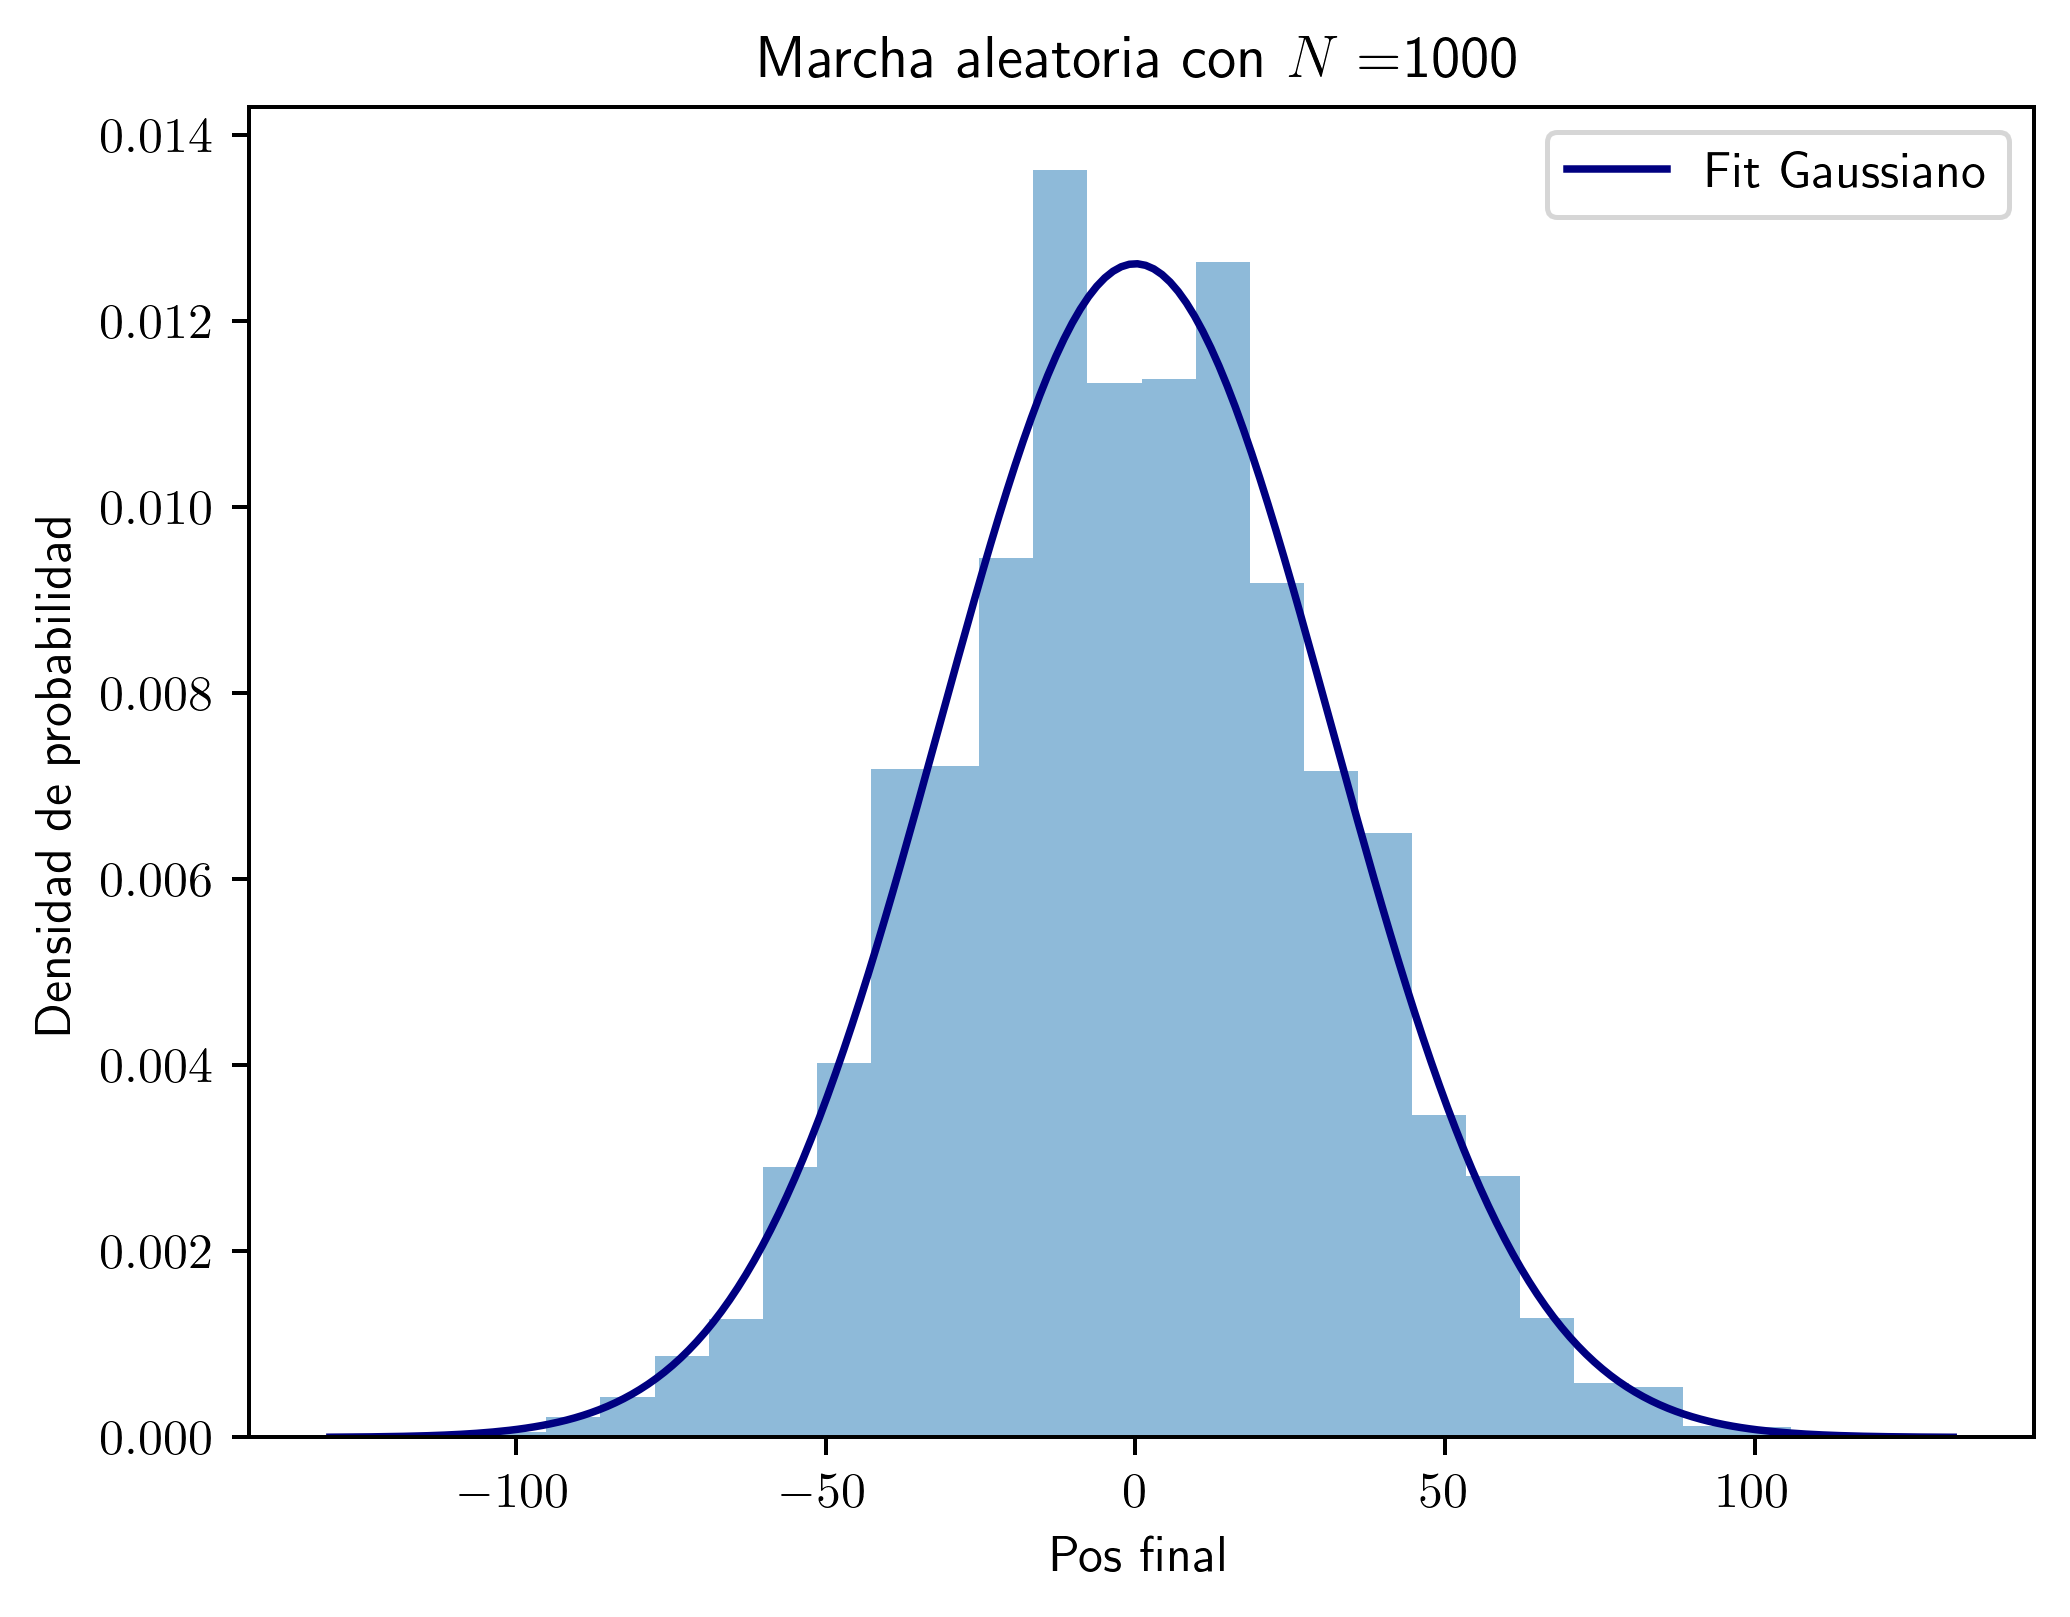

In [56]:
fig, ax = plt.subplots()
ax.hist(x, bins=30, density=True, alpha=0.5)

grilla = np.linspace(min(x), max(x), 200)
ax.plot(grilla, gaussiana_tcl(grilla, N, a), color='navy', label='Fit Gaussiano')

ax.set_xlabel('Pos final')
ax.set_ylabel('Densidad de probabilidad')
ax.set_title(f'Marcha aleatoria con $N=${N}')

ax.legend()
plt.show()

In [57]:
N_lista = np.linspace(10, 1000, 7, dtype=int)
N_lista

array([  10,  175,  340,  505,  670,  835, 1000])

In [58]:
Ns, x2_medios, m, b, D_hat = linealidad(N_lista, M, a, p, dt, rng)
m, b, D_hat

(1.0064314285714284, -1.0186714285713947, 0.5032157142857142)

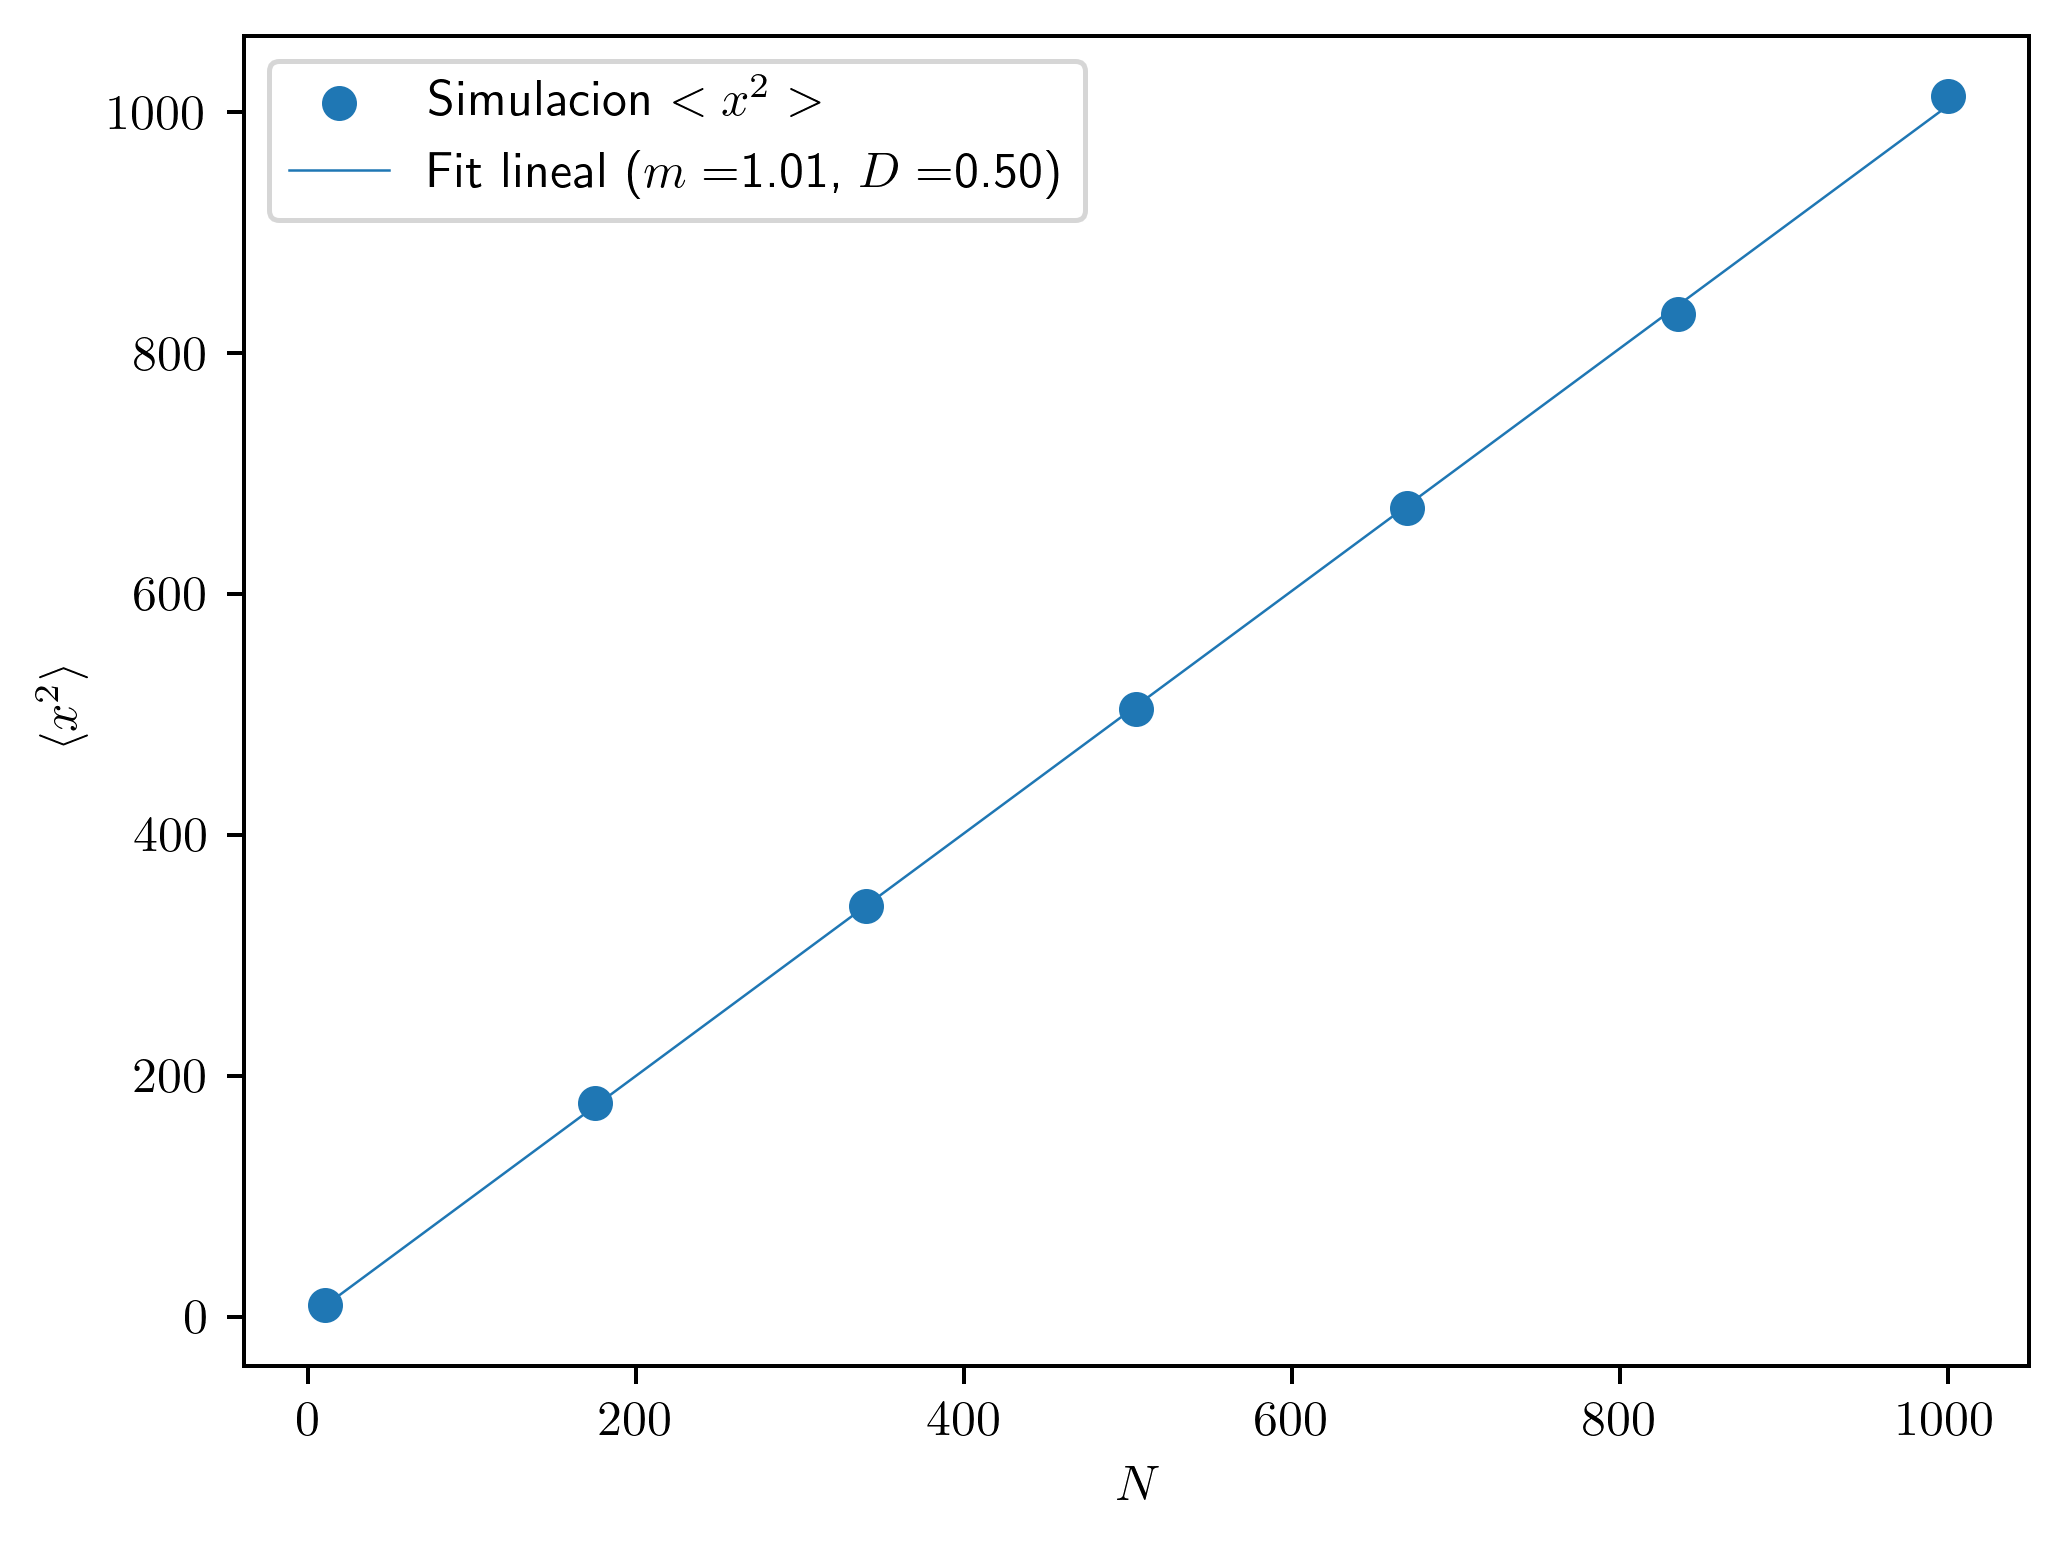

In [59]:
fig, ax = plt.subplots()

ax.scatter(Ns, x2_medios, label='Simulacion $<x^2>$')
ax.plot(Ns, m*np.array(Ns)+b, label=f'Fit lineal ($m=${m:.2f}, $D=${D_hat:.2f})', lw=0.5)

ax.set_xlabel('$N$')
ax.set_ylabel(r'$\langle x^2 \rangle$')
ax.legend()
plt.show()

---

In [60]:
def tray_completas(M, N, a, p, rng):
    """
    Genera M trayectorias completas (usando todas las posiciones intermedias)
    """
    pasos = np.where(rng.random((M, N)) < p, 1, -1).astype(np.int8)
    paths = (a * pasos).cumsum(axis=1)
    x_final = paths[:, -1]
    return paths, x_final

In [61]:
caminos, finales = tray_completas(5, 100, a, p, rng)

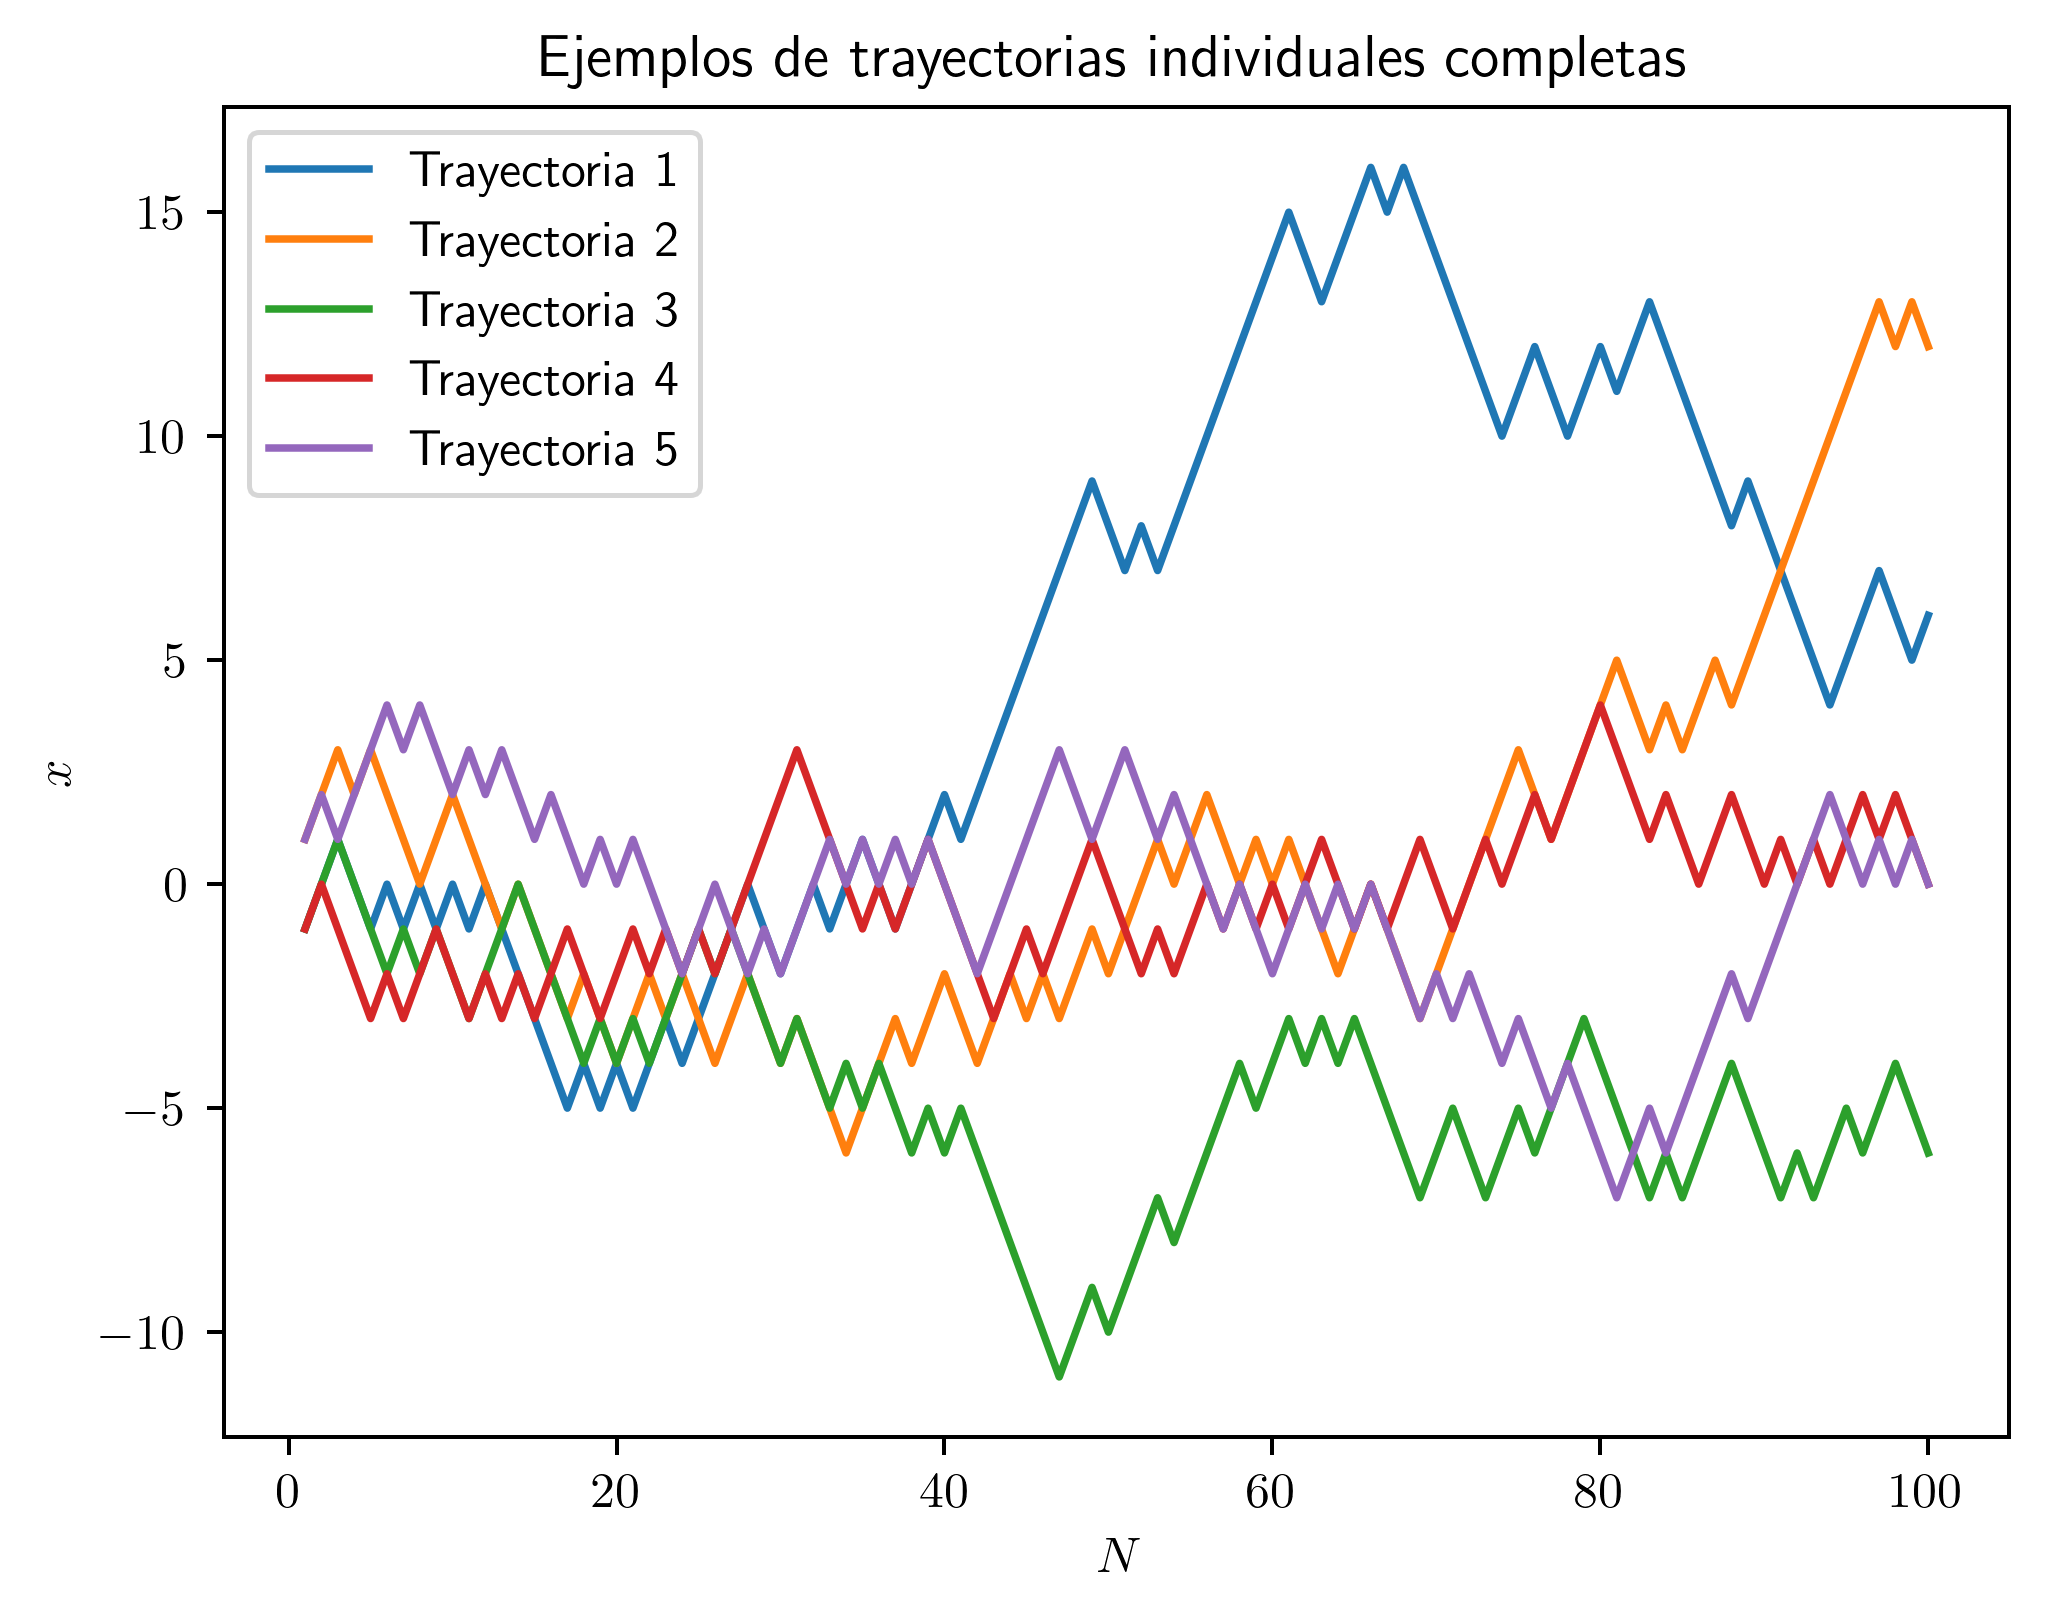

In [62]:
fig, ax = plt.subplots()

for j in range(5):
    ax.plot(range(1, 101), caminos[j], label=f'Trayectoria {j+1}')

ax.set_xlabel('$N$')
ax.set_ylabel('$x$')
ax.set_title('Ejemplos de trayectorias individuales completas')
ax.legend()
plt.show()
